In [96]:
import warnings

warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier, Pool, metrics, EFeaturesSelectionAlgorithm
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import umap.umap_ as umap
import shap

from pandarallel import pandarallel
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # to manipulate x-tickers
import plotly.express as px
import seaborn as sns

from collections import Counter
from tqdm import tqdm
import warnings
import logging
import random
import pickle
import json
import os

from IPython.core.interactiveshell import InteractiveShell

# from samolet_parking_lot.modules.cv import *
from samolet_parking_lot.modules.feature_engineering import *
from samolet_parking_lot.modules.features_selection import *
from samolet_parking_lot.modules.hyperparam_tuning import *
from samolet_parking_lot.modules.model import *
from samolet_parking_lot.modules.utils import *

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
logger = logging.getLogger(__name__)

sns.set(rc={'figure.figsize': (20, 10), 'figure.facecolor': 'white'})
sns.set_palette("viridis")
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
os.environ["TOKENIZERS_PARALLELISM"] = "true"  # activate parallelism
pandarallel.initialize(progress_bar=True)
InteractiveShell.ast_node_interactivity = "all"  # show all outputs, not only the last
seed_everything()

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Stage 1. Data Preparation

In [125]:
data = pd.read_csv("../data/raw/train_dataset_Самолет.csv")

In [126]:
data = create_date_features(data)

In [130]:
# drop columns with big share of missing values
not_null_columns_names = get_not_null_columns_names(data, threshold=.999)
# X_train = X_train[null_columns_names]
data_for_split = data[not_null_columns_names]

In [118]:
# def target_rate_improvements(data, subjects, extra):
#     """Compute the improvement in squared difference between the positive rate in each fold vs the overall positive rate in the dataset"""
#     target_rate = data['target'].mean()
#     rate_without_extra = data.loc[lambda d: d['client_id'].isin(subjects), 'target'].mean()
#     rate_with_extra =  data.loc[lambda d: d['client_id'].isin(subjects + [extra]), 'target'].mean()
#     rate_without_extra = 0 if np.isnan(rate_without_extra) else rate_without_extra
# 
#     return (rate_without_extra - target_rate)**2 - (rate_with_extra - target_rate)**2
# 
# 
# def size_improvement(data, subjects, n_folds):
#     """compute the improvement in squared difference between the number of observations in each fold vs the expected number of observations"""
#     target_obs_per_fold = len(data) / n_folds
# 
#     return [(target_obs_per_fold - len(data.loc[lambda d: d['client_id'].isin(subject)])) ** 2 for subject in subjects.values()]
# 
# n_folds = 5
# test_subjects_per_fold = {fold: [] for fold in range(n_folds)}
# subjects_to_assign = list(range(100))
# 
# for subject in tqdm(data['client_id'].unique()):
#     target_rate_improvement = np.array([target_rate_improvements(data, test_subjects_per_fold[fold], subject) for fold in range(n_folds)])
#     size_improvements = np.array(size_improvement(data, test_subjects_per_fold, n_folds)) * 0.001
#     best_fold = np.argmax(target_rate_improvement +size_improvements)
#     test_subjects_per_fold[best_fold] += [subject]

In [119]:
# for fold, subjects in test_subjects_per_fold.items():
#     print('-'*80)
#     print(f'for fold {fold}')
#     test_data = data.loc[lambda d: d['client_id'].isin(subjects)]
#     train_data = data.loc[lambda d: ~d['client_id'].isin(subjects)]
# 
#     print('train - pos rate:', train_data['target'].mean(), 'size:', len(train_data))
#     print('test - pos rate:', test_data['target'].mean(), 'size:', len(test_data))

In [ ]:
# split on train, valid, test with client_id being only withing one split
X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_valid_test_split(data_for_split)  # fix potential problem (connected to first getting non_null columns, and then removing target, client_id, date) if time will be

# Stage 2. Data Analysis

### Data Inspection

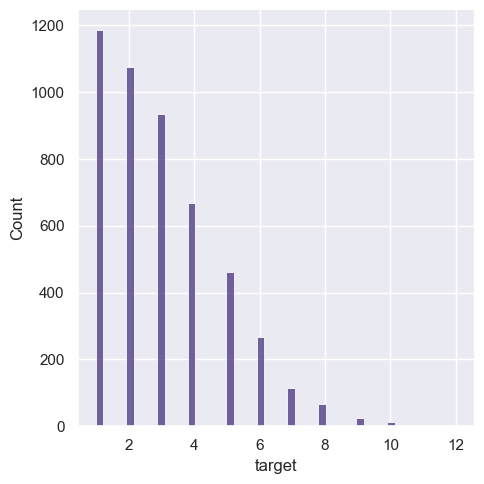

In [25]:
# Qnt of entries per client_id
plt_data = data[['client_id', 'target']].groupby('client_id', as_index=True)['target'].count()
ax = sns.displot(plt_data)
plt.show()

In [26]:
plt_data = (
    data[['client_id', 'target']]
    .groupby('client_id', as_index=True)
    .agg(qnt=('target', 'count'),
         sum=('target', 'sum'))
)
plt_data['success_share'] = plt_data['sum'] / plt_data['qnt']

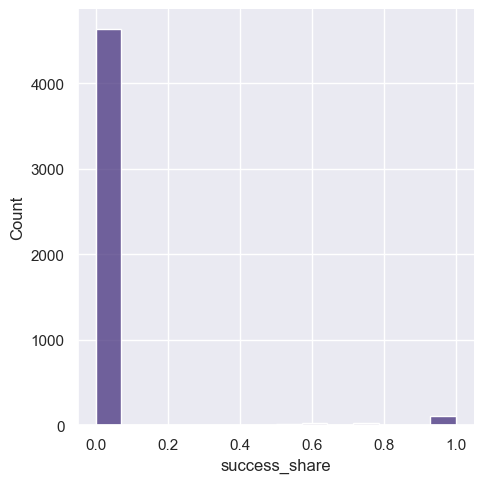

In [27]:
# distribution of share of successful events per client
ax = sns.displot(plt_data.success_share)
plt.show()

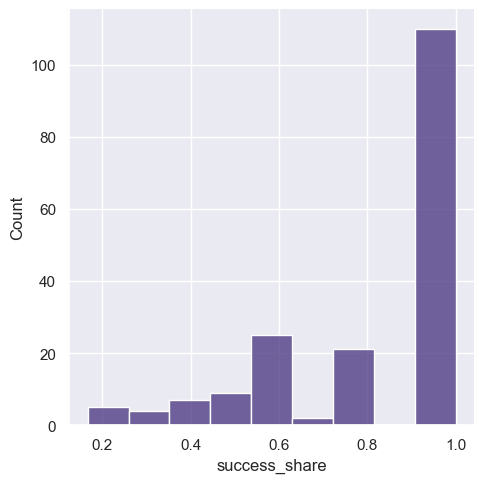

In [28]:
# distribution of share of successful events per client (w/o 0%) (among those who purchases parking lot)
ax = sns.displot(plt_data.query("success_share > 0").success_share)
plt.show()

In [29]:
# share of clents with 1
(
    data[['client_id', 'target']]
    .groupby('target', as_index=True)
    .agg(qnt=('client_id', 'count'))
)

,qnt
target,
0,14020
1,436


### Plot Possible Clusters

In [30]:
data_umap = data[data.select_dtypes(include=['float64', 'int64']).columns].fillna(0)
data_umap = StandardScaler().fit_transform(data_umap)

In [31]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data_umap)
embedding.shape

(14456, 2)

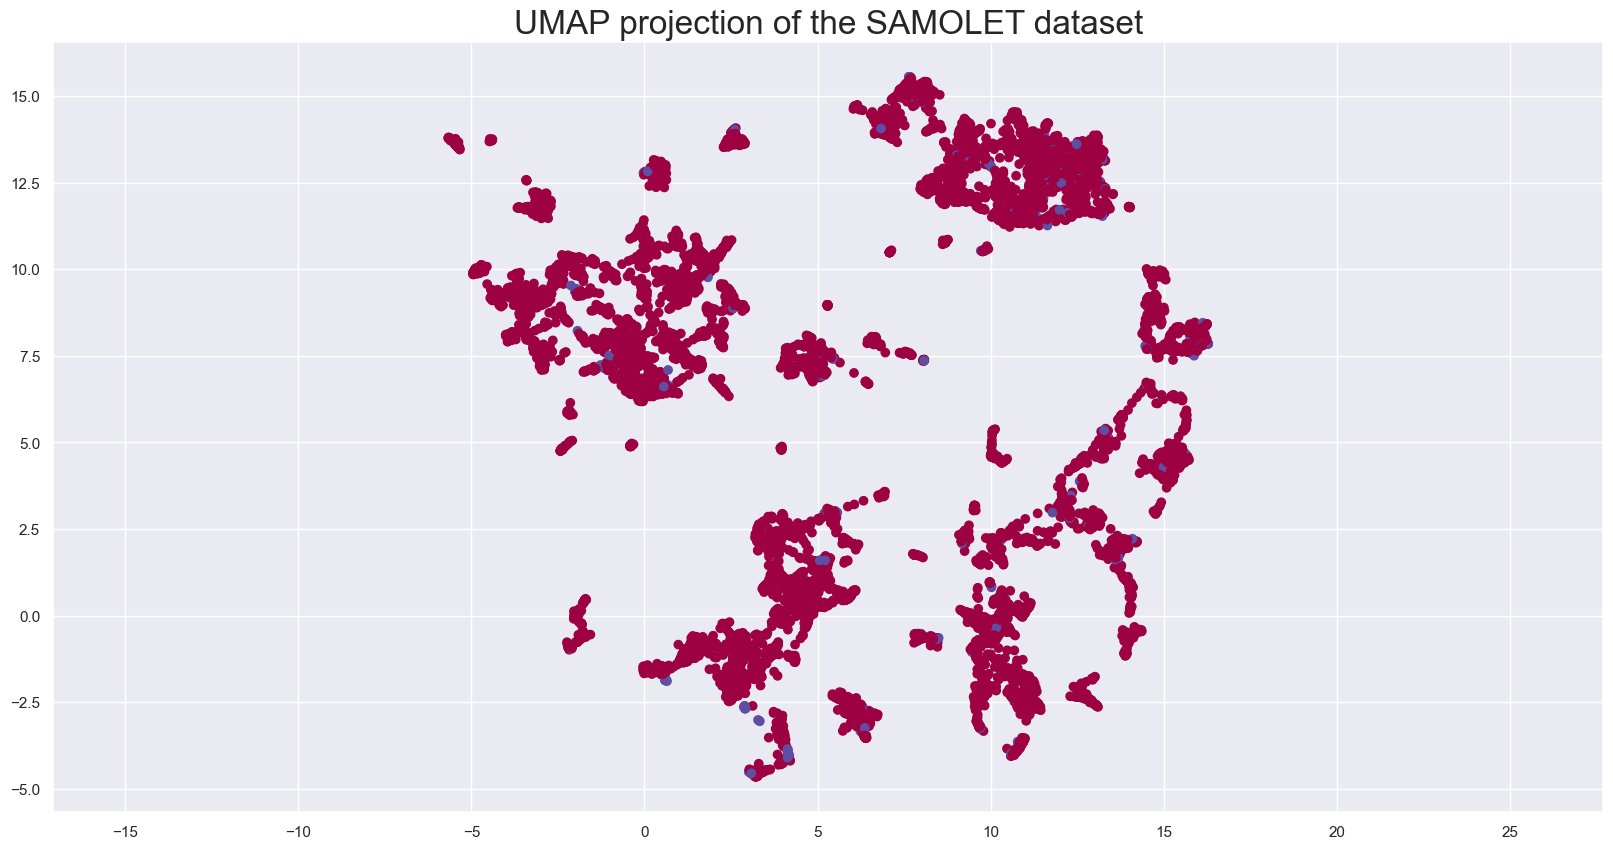

In [32]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=data.target,
    cmap='Spectral',
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the SAMOLET dataset', fontsize=24);

### Dimensionality Reduction

In [33]:
data_umap = X_train[X_train.select_dtypes(include=['float64', 'int64']).columns].fillna(0)
data_umap = StandardScaler().fit_transform(data_umap)

In [34]:
reducer = umap.UMAP(n_components=50)
umap_embedding = reducer.fit_transform(data_umap)

In [35]:
pca = PCA(n_components=400, svd_solver='full')
pca_embedding = pca.fit_transform(data_umap)

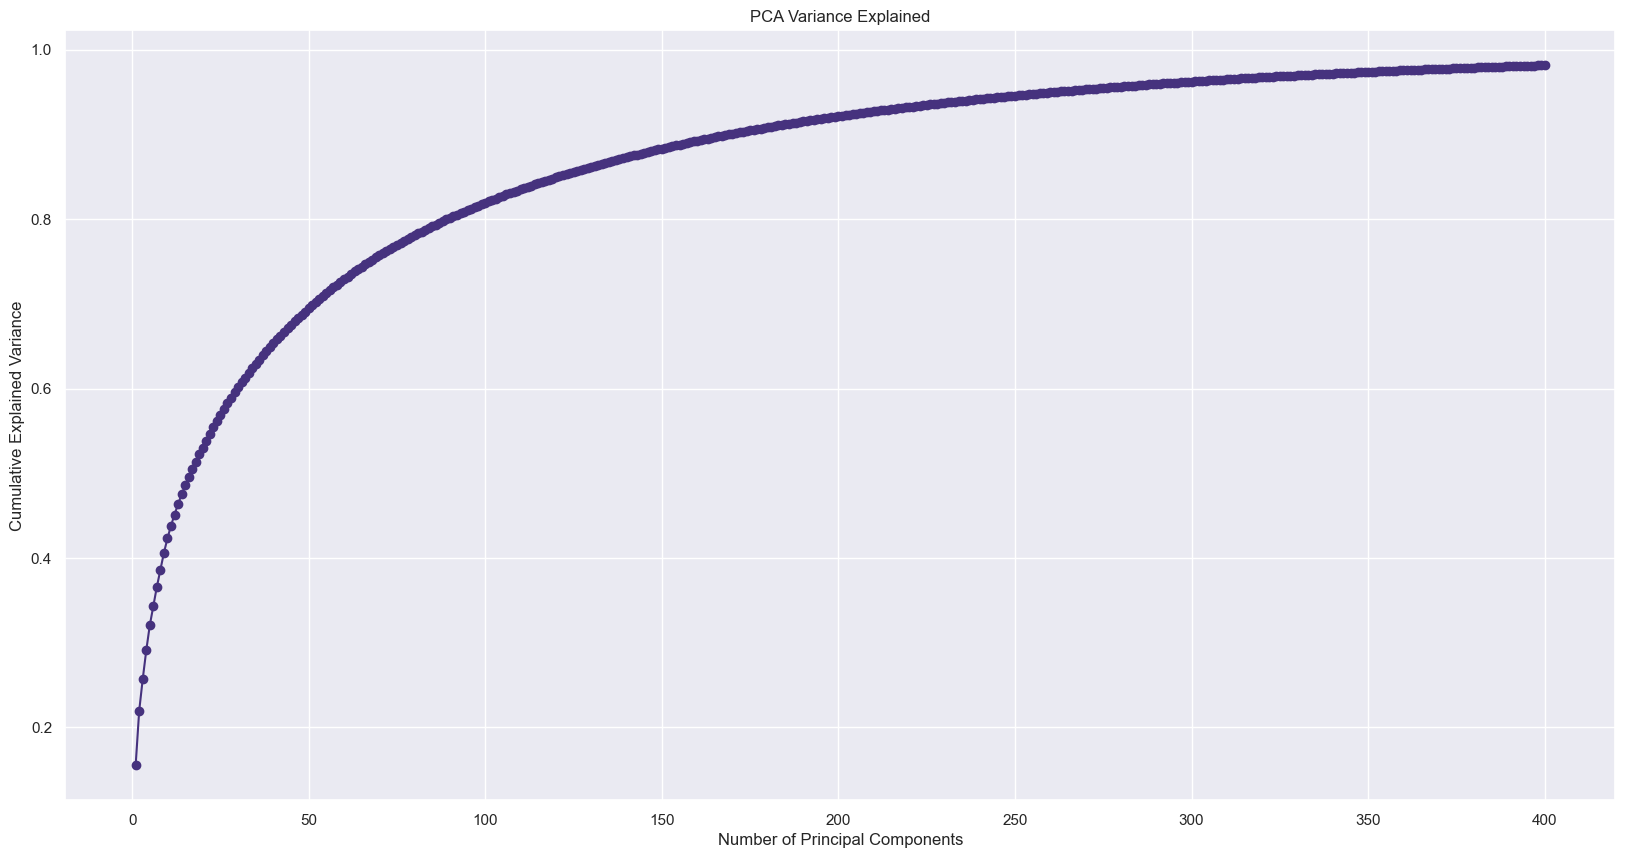

Plot was saved to PCA_varian_without_UMAP


<Figure size 2000x1000 with 0 Axes>

In [36]:
plot_pca_variance(pca, save_to="PCA_varian_without_UMAP")

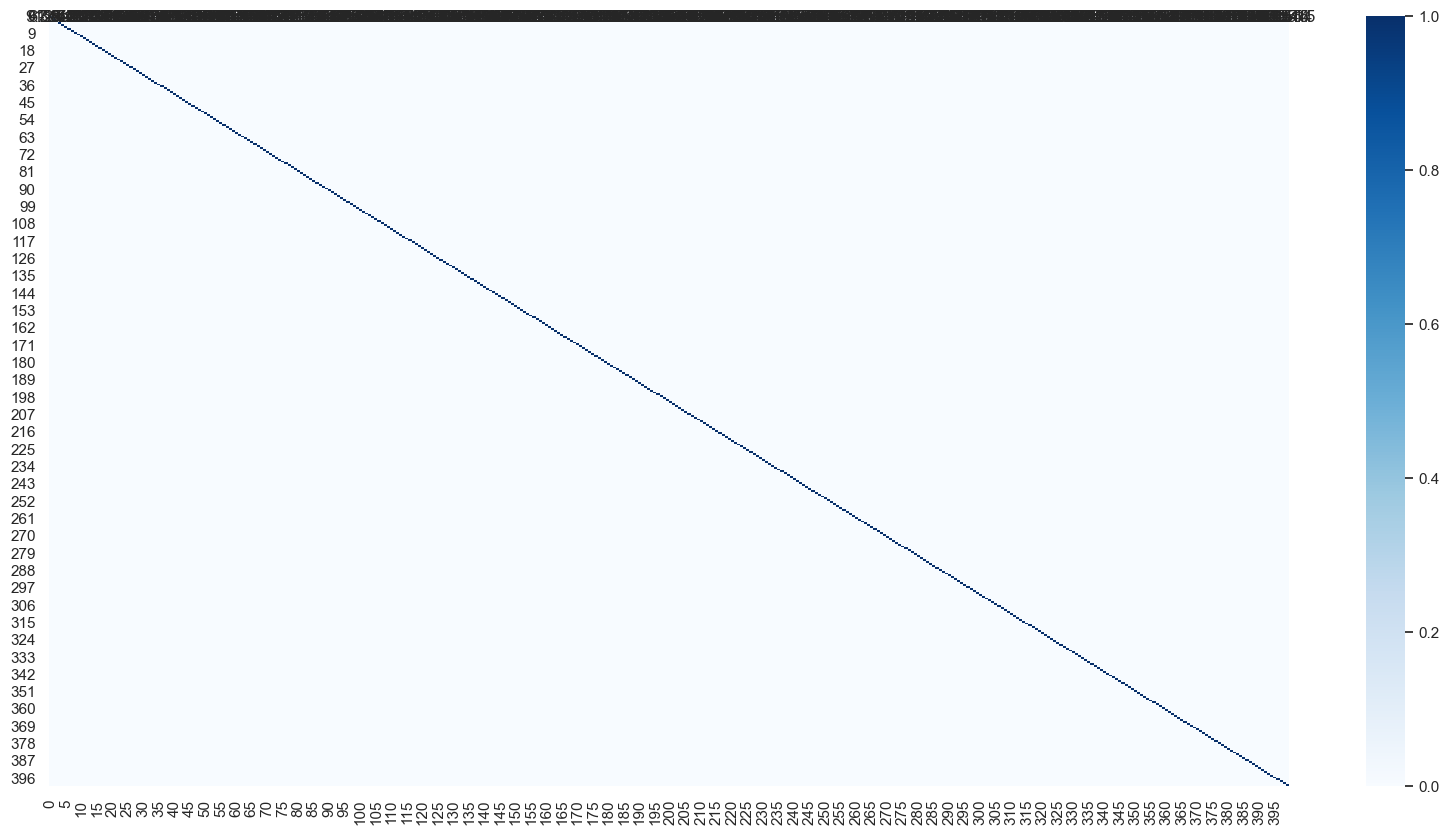

In [37]:
ax = sns.heatmap(pd.DataFrame(pca_embedding).corr(), annot=True, cmap='Blues')
plt.show()

# Stage 3. Model (w/o Feature Selection)

In [38]:
model = catboost_model_classifier(X_train, X_valid, y_train, y_valid)
y_pred = model.predict(X_test)
roc_auc_score(y_test, y_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.8719916502946956

ROC-AUC score is:  0.8719916502946956


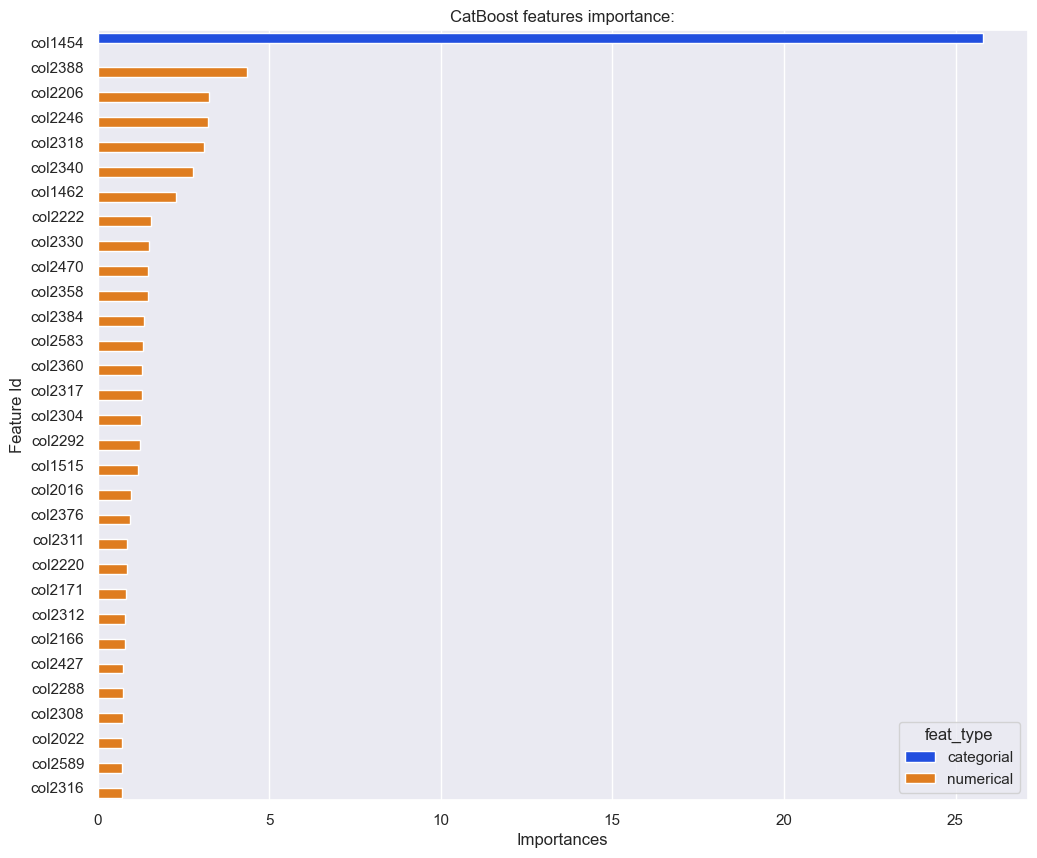

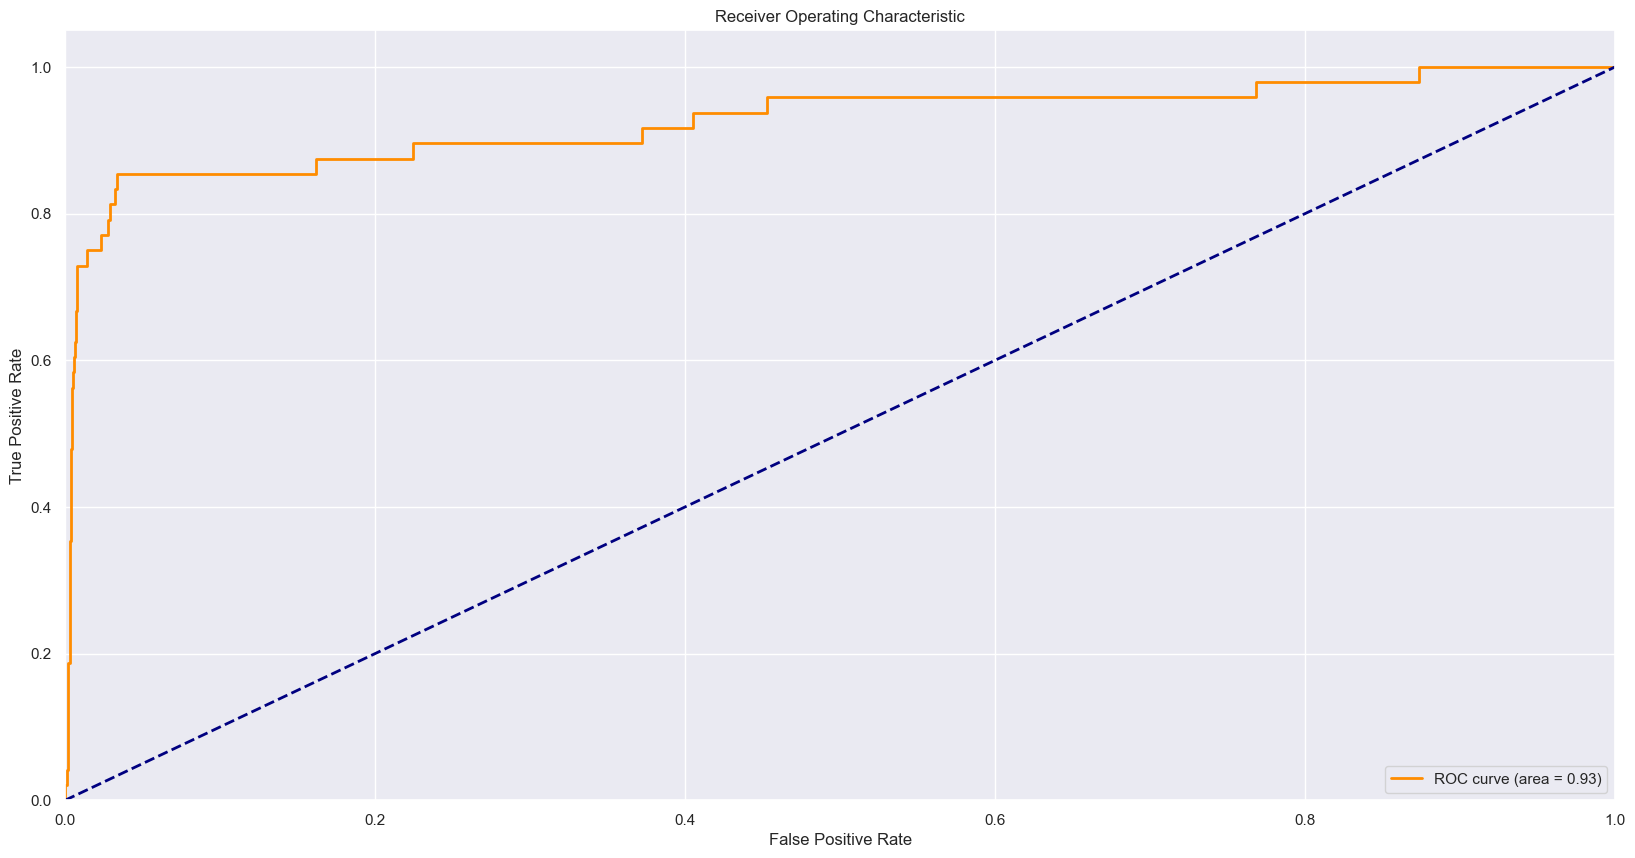

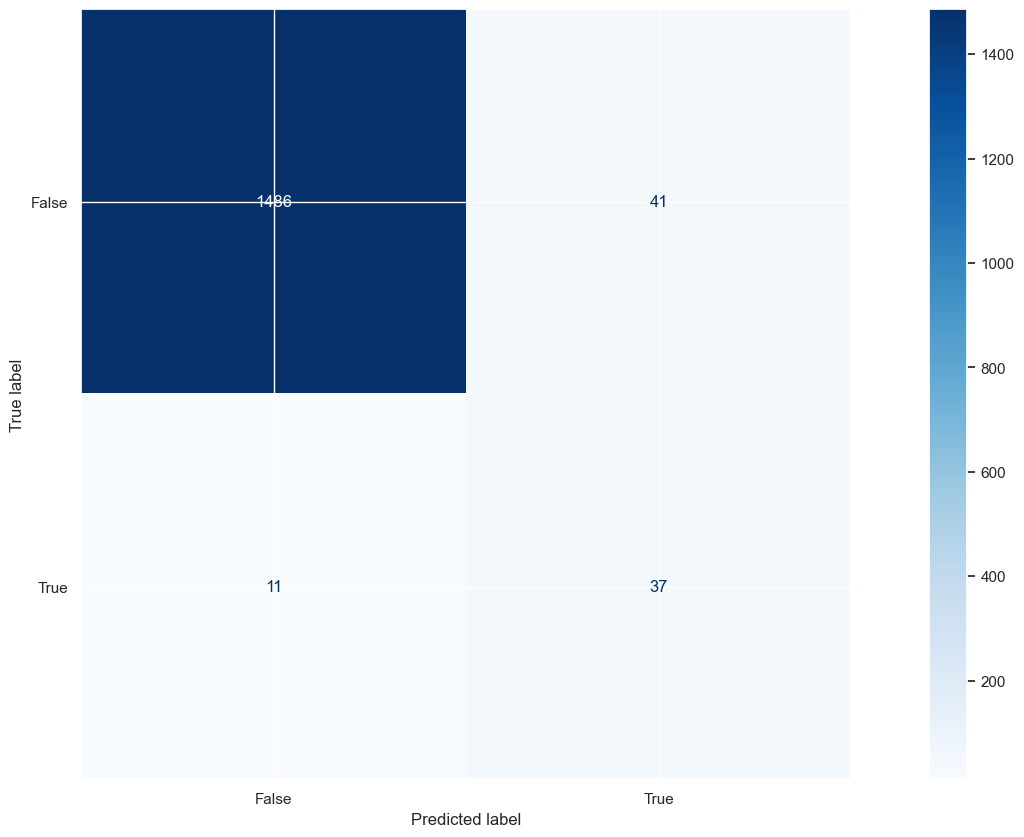

In [39]:
plot_model_info(model, X_test, y_test)  #categorical_columns

# Step 4. Feature Selection

In [40]:
useful_column_indices_sk = get_sklearn_important_features(model, X_train, X_test, y_test, plot=False)
useful_column_indices_rf = get_random_feat_important_features(X_train, y_train, X_valid, y_valid)
useful_column_indices_union = list(set(useful_column_indices_sk + useful_column_indices_rf))
useful_column_indices_intersect = lists_intersection(useful_column_indices_sk, useful_column_indices_rf)

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
2023-09-09 22:49:15,586 INFO From 2407 feature 64 were selected (0.03%).Share of 'Object' type features is: 0.00%


KeyError: 'random'

In [ ]:
# compare both feature extraction methods
lists_analysis(useful_column_indices_sk, useful_column_indices_rf)

In [41]:
useful_column_indices = useful_column_indices_sk
X_train_cleaned = X_train.iloc[:, useful_column_indices]
X_valid_cleaned = X_valid.iloc[:, useful_column_indices]
X_test_cleaned = X_test.iloc[:, useful_column_indices]

In [42]:
model_cleansed = catboost_model_classifier(
    X_train_cleaned,
    X_valid_cleaned,
    y_train, y_valid
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

ROC-AUC score is:  0.9032416502946955


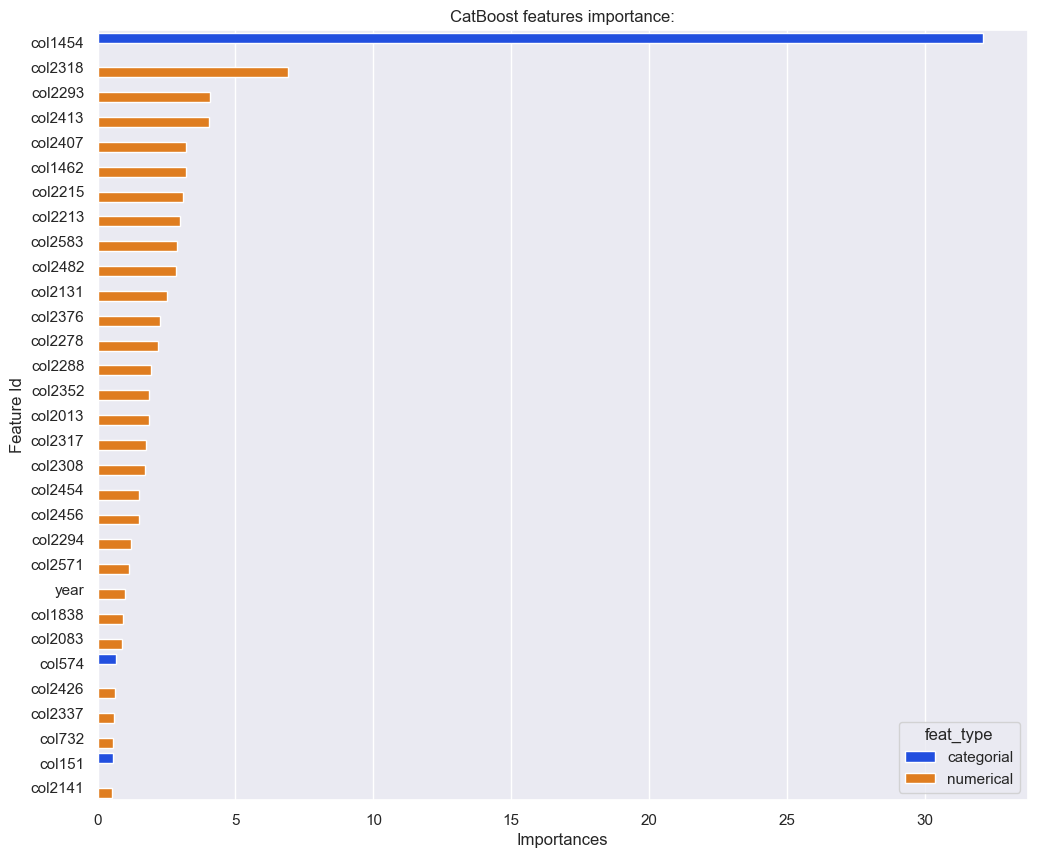

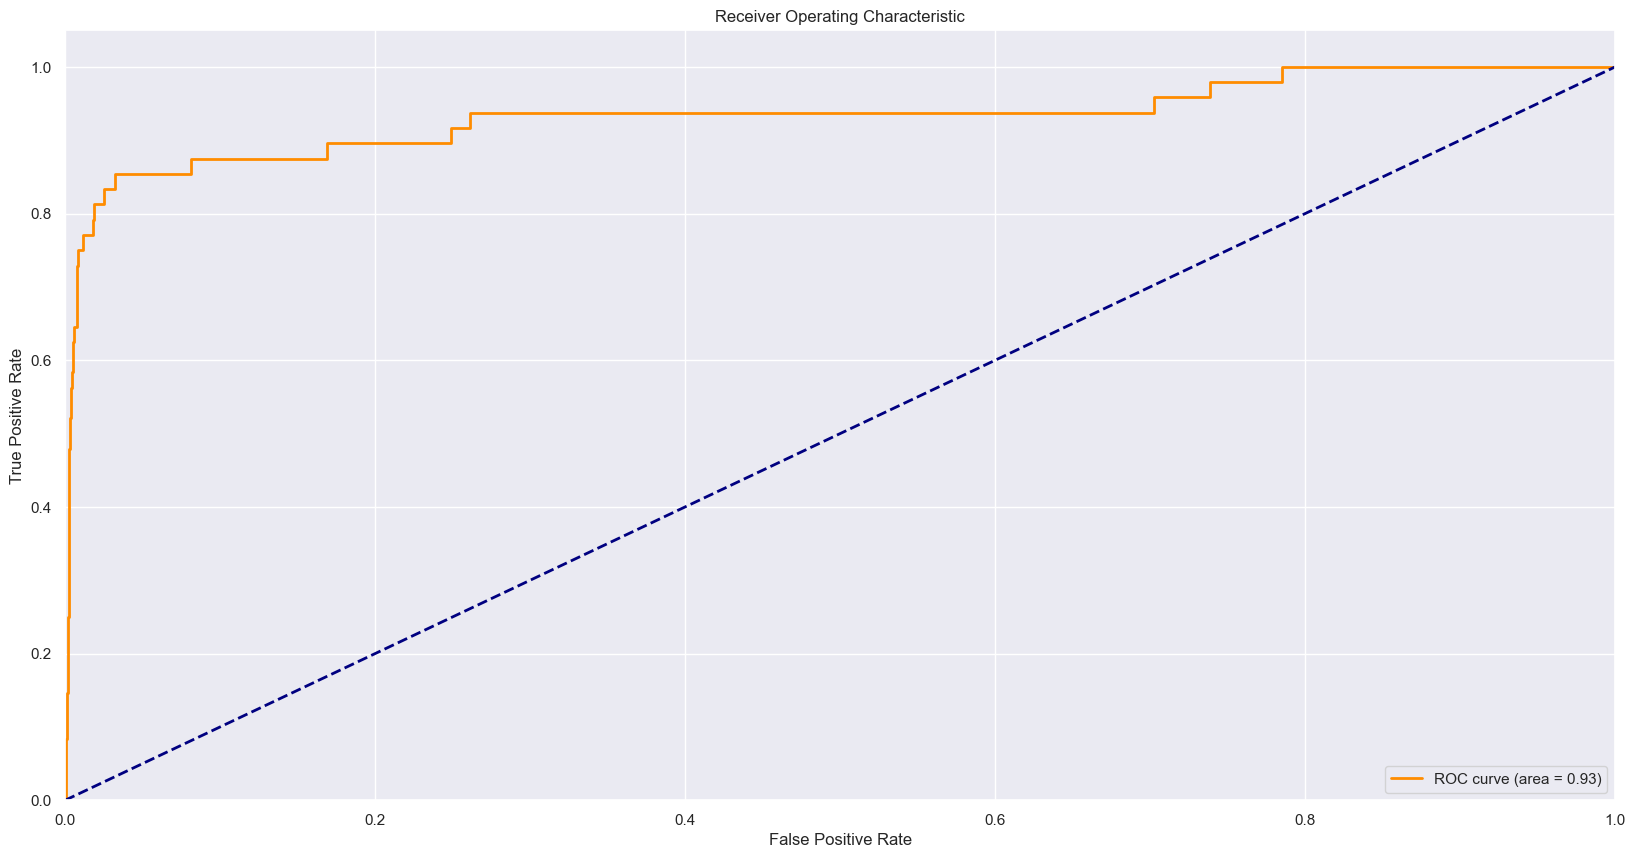

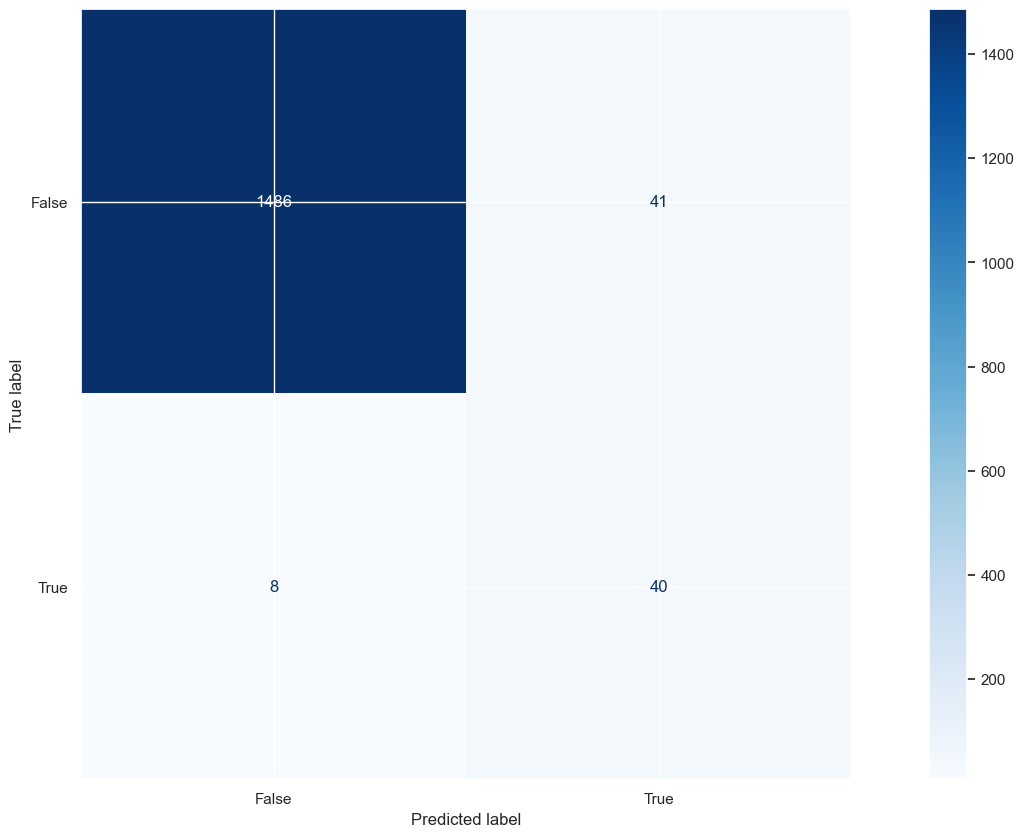

In [43]:
plot_model_info(
    model_cleansed,
    X_test_cleaned,
    y_test,
    # X_test_cleaned.select_dtypes(exclude=["float64", "int64"]).columns.to_list()
)

# Step 5. Hyperparameters Tuning

In [44]:
search_new_params = False
if search_new_params:
    hyperparams = search_best_params(X_train_cleaned, X_valid_cleaned, y_train, y_valid, max_evals=300)
else:
    with open('best_hyperparams_full_dataset.pkl', 'rb') as fp:
        hyperparams = pickle.load(fp)

In [45]:
# with open('best_hyperparams_full_dataset.pkl', 'wb') as fp:
#     pickle.dump(hyperparams, fp)

In [46]:
params = {
    'learning_rate': hyperparams['learning_rate'],
    'iterations': hyperparams['iterations'],
    'depth': hyperparams['depth'],
    'loss_function': 'Logloss',
    'l2_leaf_reg': hyperparams['l2_leaf_reg'],
    'eval_metric': 'Logloss',
    'early_stopping_rounds': 20,
    'random_seed': 42,
    'auto_class_weights': "Balanced",
}

In [47]:
categorical_columns = X_train_cleaned.select_dtypes(exclude=['float64', 'int64']).columns.to_list()
model_best = CatBoostClassifier(**params)
model_best.fit(
    X=X_train_cleaned,
    y=y_train,
    eval_set=(X_valid_cleaned, y_valid),
    verbose=250,
    cat_features=categorical_columns
)

0:	learn: 0.5170192	test: 0.4607927	best: 0.4607927 (0)	total: 5.36ms	remaining: 762ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2915646436
bestIteration = 10

Shrink model to first 11 iterations.


In [48]:
# model_best.save_model('best_model')

ROC-AUC score is:  0.9175261951538967


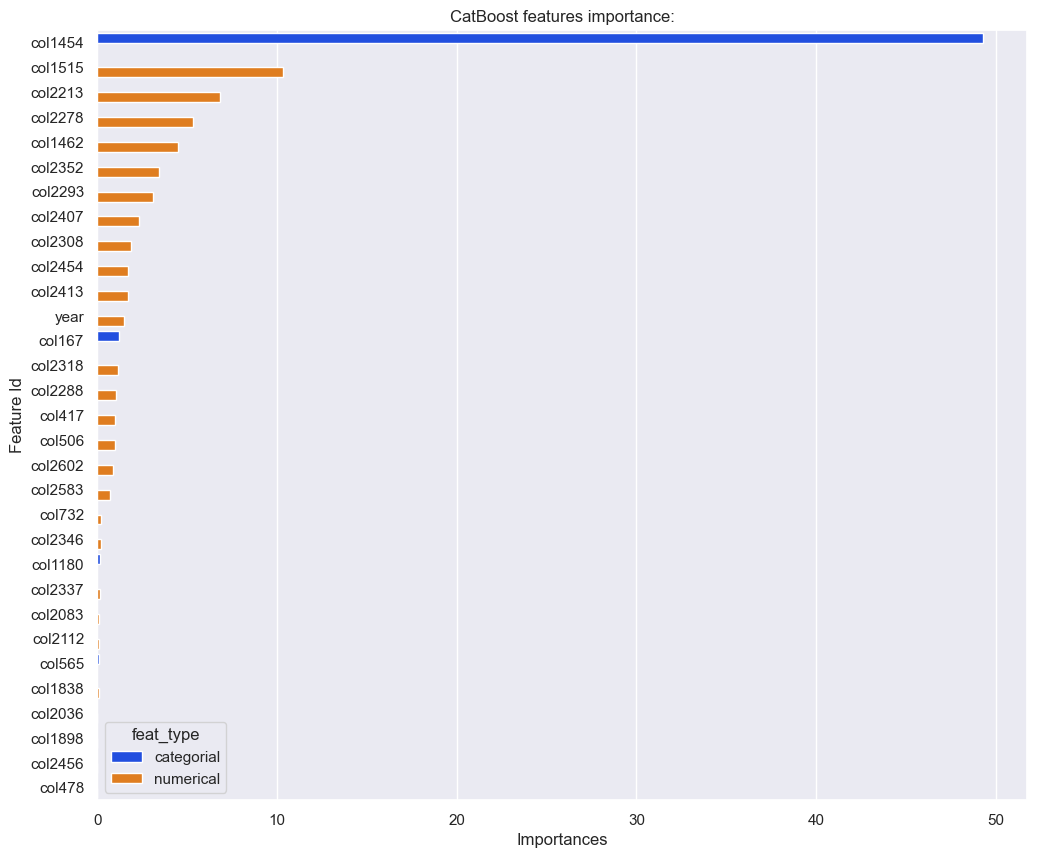

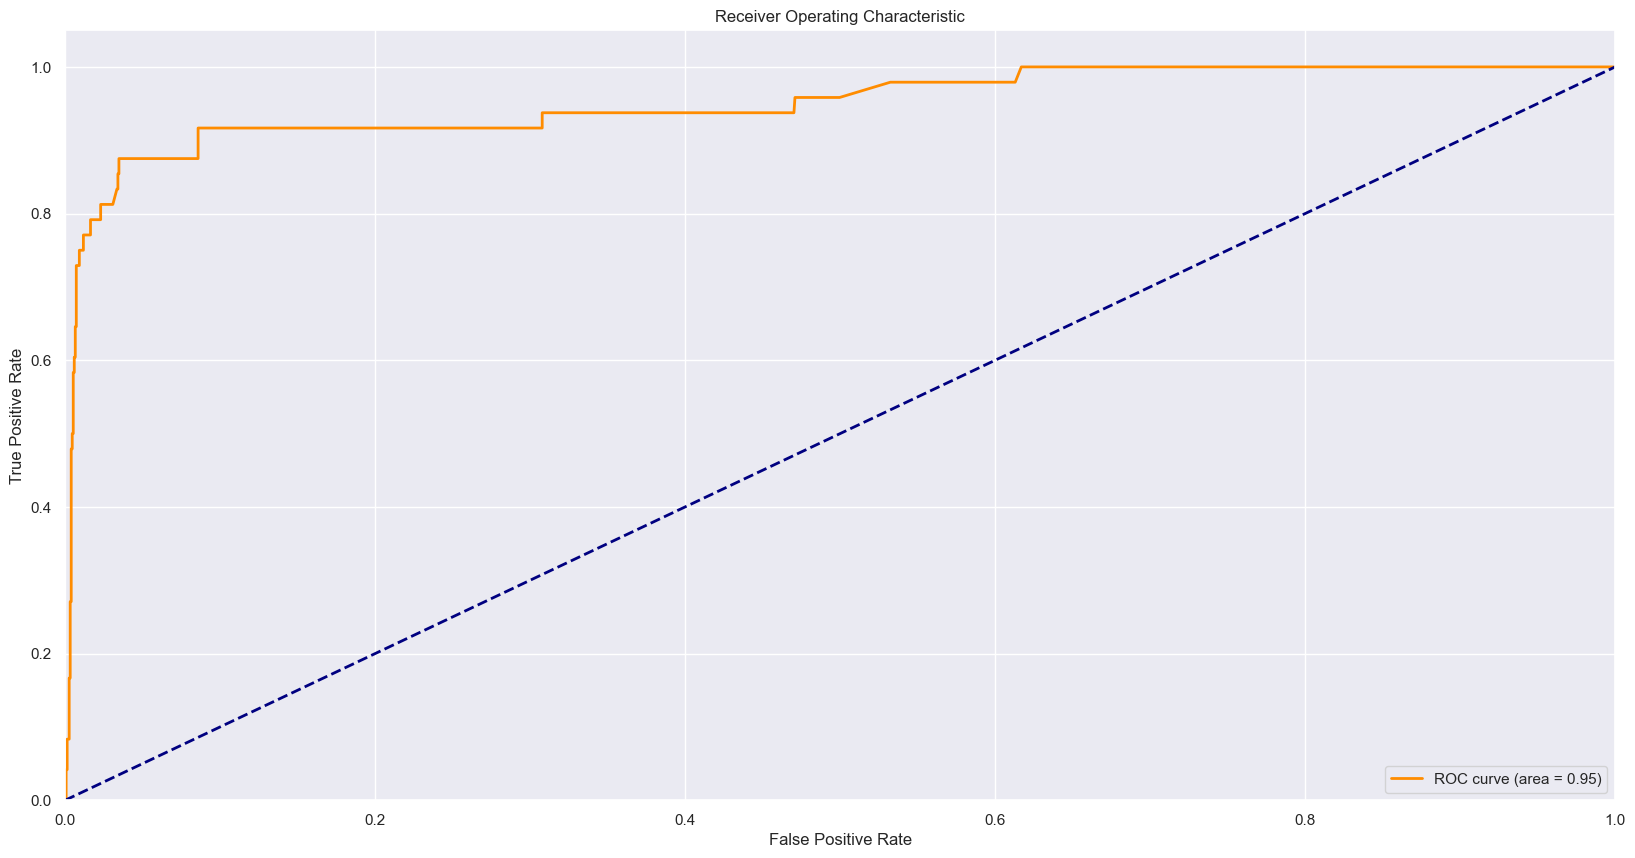

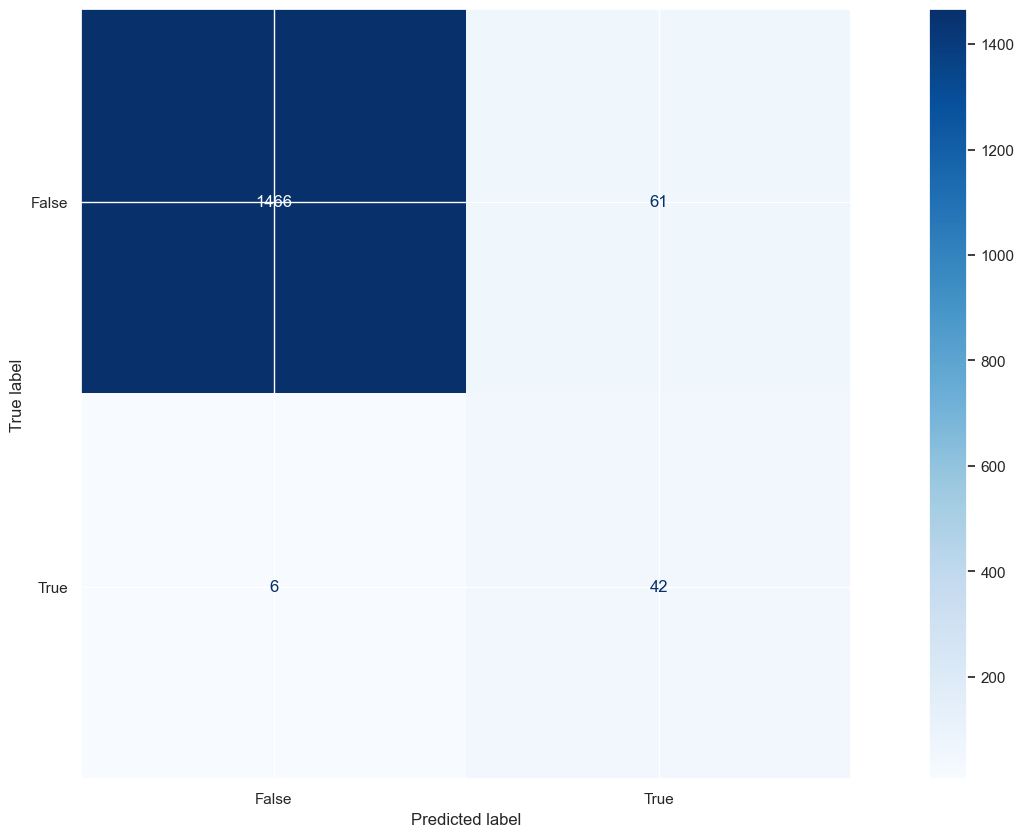

In [49]:
plot_model_info(
    model_best,
    X_test_cleaned,
    y_test,
)

# Step 6. Add Logistic Regression

In [50]:
preprocessor = get_transformer_data_for_regression(X_train_cleaned)

In [51]:
X_train_linear = preprocessor.transform(X_train_cleaned)
X_test_linear = preprocessor.transform(X_test_cleaned)

PCA(n_components=64, svd_solver='full')

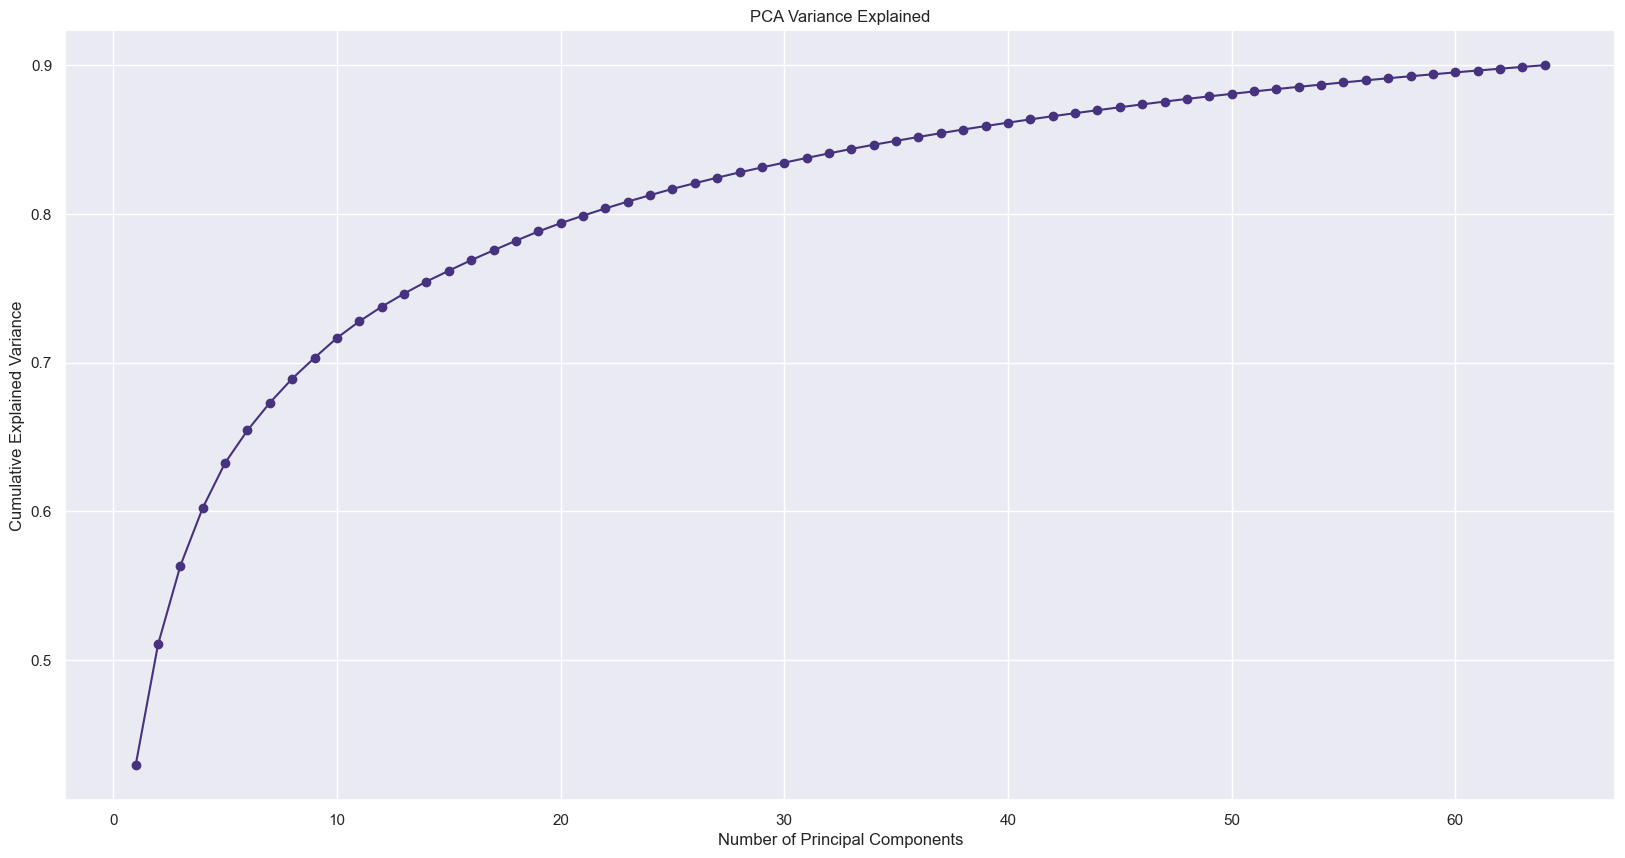

In [52]:
pca = PCA(n_components=min(100, len(X_train_cleaned.columns)), svd_solver='full')
pca.fit(X_train_linear)
plot_pca_variance(pca)

In [53]:
top_n = 60
train_pca = pca.fit_transform(X_train_linear)[:, :top_n]  # we select only top N features
test_pca = pca.transform(X_test_linear)[:, :top_n]

### LogisticRegression

In [54]:
logreg = LogisticRegression(random_state=42, class_weight='balanced', n_jobs=10)
logreg.fit(train_pca, y_train)

/Users/filin_va/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', n_jobs=10, random_state=42)

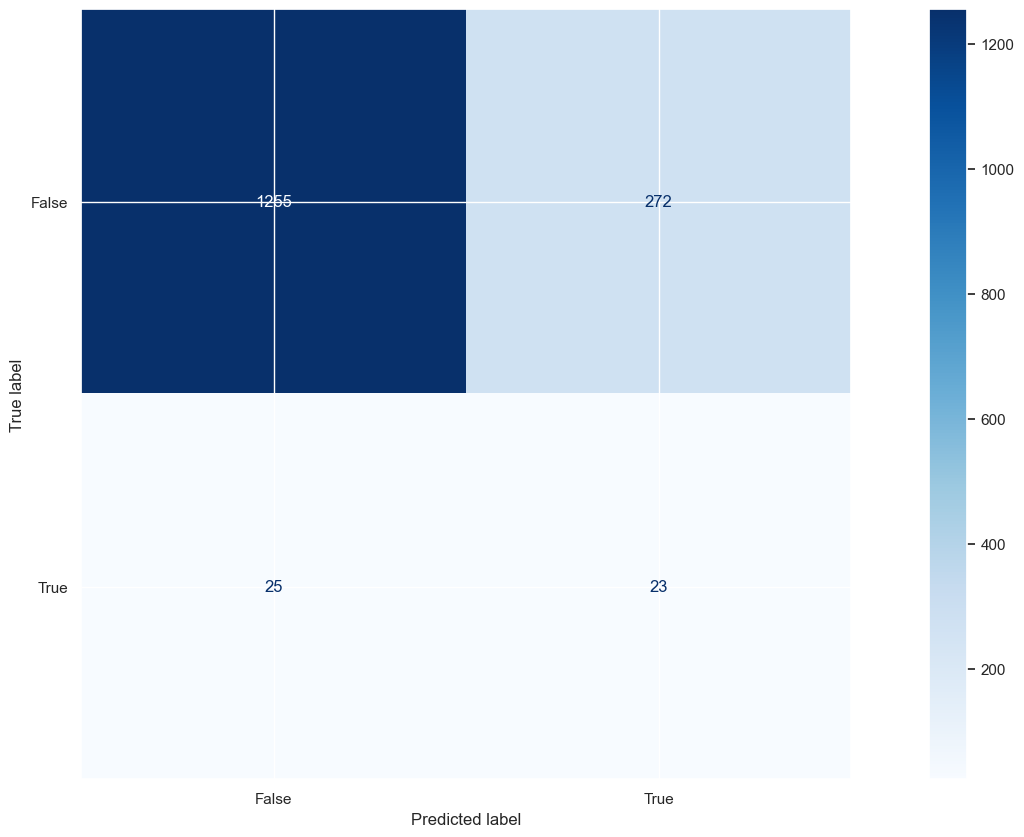

In [55]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, logreg.predict(test_pca)), display_labels=[False, True])
cm_display.plot(cmap="Blues")
plt.show()

### LogisticRegressionCV

In [56]:
logreg_cv = LogisticRegressionCV(cv=5, random_state=42, class_weight='balanced', penalty='l2', n_jobs=10)
logreg_cv.fit(train_pca, y_train)

/Users/filin_va/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/filin_va/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

LogisticRegressionCV(class_weight='balanced', cv=5, n_jobs=10, random_state=42)

ROC-AUC score is:  0.6196586444007858


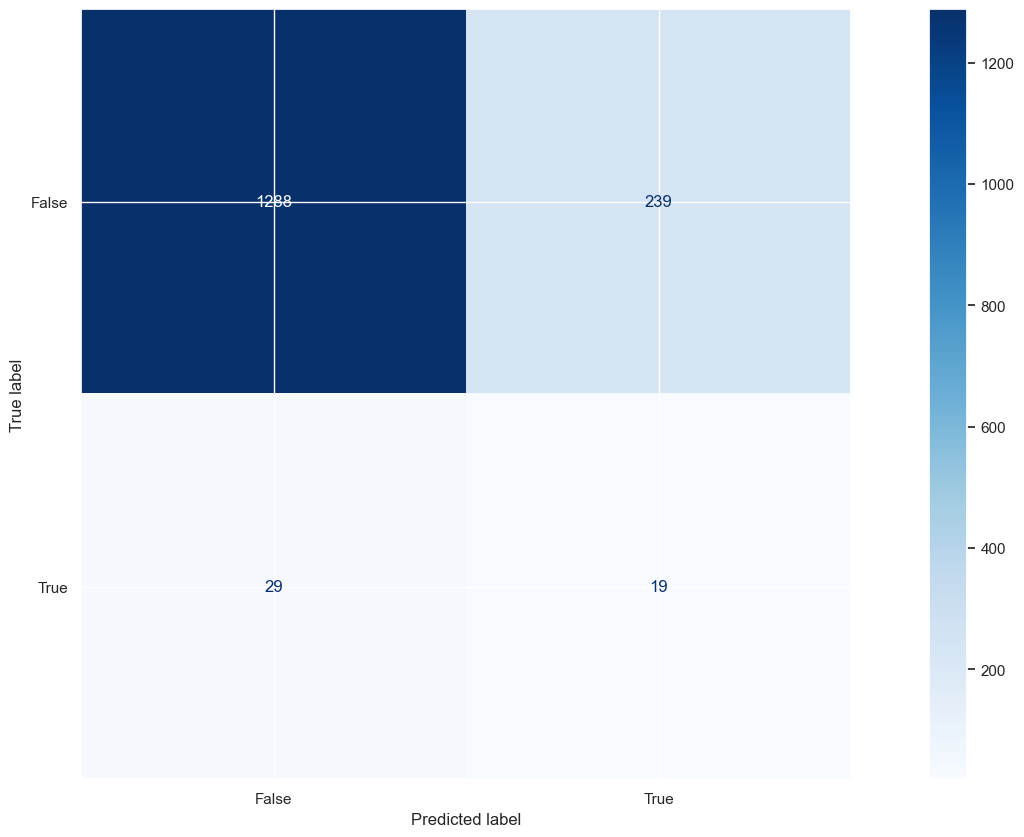

In [57]:
print("ROC-AUC score is: ", roc_auc_score(y_test, logreg_cv.predict(test_pca)))
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, logreg_cv.predict(test_pca)), display_labels=[False, True])
cm_display.plot(cmap="Blues")
plt.show()

# Step 7. CV

In [106]:
# from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, early_stop
# from catboost import CatBoostClassifier, cv, Pool
# 
# 
# def search_best_params_cv(
#         X_train, X_val, y_train, y_val, max_evals=100, early_stop_steps=50
# ):
#     def objective(space):
#         # Modify the parameters to be used in CatBoost
# 
#         # Perform cross-validation and return the average AUC
#         params = {
#             "learning_rate": space["learning_rate"],
#             "iterations": int(space["iterations"]),
#             "l2_leaf_reg": space["l2_leaf_reg"],
#             "depth": space["depth"],
#             "random_strength": space["random_strength"],
#             "border_count": space["border_count"],
#             "bagging_temperature": space["bagging_temperature"],
#             "loss_function": "Logloss",
#             "random_seed": 42,
#             "logging_level": "Silent",
#             "auto_class_weights": "Balanced",
#             "early_stopping_rounds": 20,
#         }
#         cv_results = cv(pool, params, fold_count=5)
#         avg_auc = np.mean(cv_results["test-Logloss-mean"])
#         return {"loss": avg_auc, "status": STATUS_OK}
# 
#     # Get categorical and numerical columns
#     categorical_columns = X_train.select_dtypes(exclude=["float64", "int64"]).columns
#     numerical_columns = X_train.select_dtypes(include=["float64", "int64"]).columns
# 
#     # Fill NA values and convert data types
#     X_train[numerical_columns] = X_train[numerical_columns].fillna(0).astype(int)
#     X_train[categorical_columns] = X_train[categorical_columns].astype(str)
# 
#     # Create a Pool object
#     global pool
#     pool = Pool(X_train, y_train, cat_features=categorical_columns.to_list())
# 
#     # Define the hyperparameter space
#     search_space = {
#         "learning_rate": hp.uniform("learning_rate", 0.1, 0.5),
#         "iterations": hp.randint("iterations", 100, 500),
#         "l2_leaf_reg": hp.randint("l2_leaf_reg", 1, 10),
#         "depth": hp.randint("depth", 4, 10),
#         "random_strength": hp.choice("random_strength", (0.0, 1.0)),
#         "border_count": hp.qloguniform("border_count", np.log(32), np.log(255), 1),
#         "bagging_temperature": hp.loguniform(
#             "bagging_temperature", np.log(1), np.log(3)
#         ),
#     }
# 
#     # Run the hyperparameter optimization
#     trials = Trials()
#     best = fmin(objective, search_space, algo=tpe.suggest, max_evals=50, trials=trials)
# 
#     # Train the final model on the entire dataset with the best found parameters
#     best_params = {
#         "learning_rate": best["learning_rate"],
#         "iterations": int(best["iterations"]),
#         "l2_leaf_reg": best["l2_leaf_reg"],
#         "depth": best["depth"],
#         "random_strength": best["random_strength"],
#         "border_count": best["border_count"],
#         "bagging_temperature": best["bagging_temperature"],
#         "loss_function": "Logloss",
#         "random_seed": 42,
#         "logging_level": "Silent",
#         "auto_class_weights": "Balanced",
#         "early_stopping_rounds": 20,
#     }
#     model = CatBoostClassifier(**best_params)
# 
#     model.fit(
#         X_train,
#         y_train,
#         eval_set=(X_val, y_val),
#         cat_features=categorical_columns.to_list(),
#         plot=True,
#         verbose=False,
#     )
# 
#     # # Make predictions on the test set
#     # X_test[numerical_columns] = X_test[numerical_columns].fillna(0).astype(int)
#     # X_test[categorical_columns] = X_test[categorical_columns].astype(str)
#     # predictions = model.predict(X_test)
# 
#     return best_params

In [108]:
best_params = search_best_params_cv(X_train, X_valid, y_train, y_valid)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

2023-09-09 22:01:39,042 INFO build_posterior_wrapper took 0.001039 seconds
2023-09-09 22:01:39,042 INFO TPE using 0 trials


  2%|▏         | 1/50 [00:31<25:30, 31.24s/trial, best loss: 0.4264774961513819]

2023-09-09 22:02:10,284 INFO build_posterior_wrapper took 0.000574 seconds
2023-09-09 22:02:10,284 INFO TPE using 1/1 trials with best loss 0.426477


  4%|▍         | 2/50 [00:55<21:43, 27.15s/trial, best loss: 0.36061103400926253]

2023-09-09 22:02:34,575 INFO build_posterior_wrapper took 0.000641 seconds
2023-09-09 22:02:34,575 INFO TPE using 2/2 trials with best loss 0.360611


  6%|▌         | 3/50 [01:48<30:31, 38.97s/trial, best loss: 0.36061103400926253]

2023-09-09 22:03:27,611 INFO build_posterior_wrapper took 0.000575 seconds
2023-09-09 22:03:27,611 INFO TPE using 3/3 trials with best loss 0.360611


  8%|▊         | 4/50 [02:39<33:27, 43.64s/trial, best loss: 0.36061103400926253]

2023-09-09 22:04:18,412 INFO build_posterior_wrapper took 0.000576 seconds
2023-09-09 22:04:18,412 INFO TPE using 4/4 trials with best loss 0.360611


 10%|█         | 5/50 [02:57<25:55, 34.57s/trial, best loss: 0.36061103400926253]

2023-09-09 22:04:36,895 INFO build_posterior_wrapper took 0.000557 seconds
2023-09-09 22:04:36,895 INFO TPE using 5/5 trials with best loss 0.360611


 12%|█▏        | 6/50 [03:24<23:21, 31.85s/trial, best loss: 0.36061103400926253]

2023-09-09 22:05:03,479 INFO build_posterior_wrapper took 0.000577 seconds
2023-09-09 22:05:03,479 INFO TPE using 6/6 trials with best loss 0.360611


 14%|█▍        | 7/50 [04:26<29:59, 41.84s/trial, best loss: 0.36061103400926253]

2023-09-09 22:06:05,893 INFO build_posterior_wrapper took 0.000694 seconds
2023-09-09 22:06:05,893 INFO TPE using 7/7 trials with best loss 0.360611


 16%|█▌        | 8/50 [06:03<41:30, 59.31s/trial, best loss: 0.36061103400926253]

2023-09-09 22:07:42,584 INFO build_posterior_wrapper took 0.000621 seconds
2023-09-09 22:07:42,585 INFO TPE using 8/8 trials with best loss 0.360611


 18%|█▊        | 9/50 [06:29<33:29, 49.00s/trial, best loss: 0.36061103400926253]

2023-09-09 22:08:08,937 INFO build_posterior_wrapper took 0.000657 seconds
2023-09-09 22:08:08,937 INFO TPE using 9/9 trials with best loss 0.360611


 20%|██        | 10/50 [07:31<35:19, 52.99s/trial, best loss: 0.35974406839705014]

2023-09-09 22:09:10,859 INFO build_posterior_wrapper took 0.000603 seconds
2023-09-09 22:09:10,859 INFO TPE using 10/10 trials with best loss 0.359744


 22%|██▏       | 11/50 [07:58<29:13, 44.96s/trial, best loss: 0.35974406839705014]

2023-09-09 22:09:37,601 INFO build_posterior_wrapper took 0.000591 seconds
2023-09-09 22:09:37,601 INFO TPE using 11/11 trials with best loss 0.359744


 24%|██▍       | 12/50 [09:25<36:36, 57.81s/trial, best loss: 0.35974406839705014]

2023-09-09 22:11:04,790 INFO build_posterior_wrapper took 0.000626 seconds
2023-09-09 22:11:04,791 INFO TPE using 12/12 trials with best loss 0.359744


 26%|██▌       | 13/50 [10:00<31:16, 50.72s/trial, best loss: 0.3533401619995156] 

2023-09-09 22:11:39,216 INFO build_posterior_wrapper took 0.000591 seconds
2023-09-09 22:11:39,216 INFO TPE using 13/13 trials with best loss 0.353340


 28%|██▊       | 14/50 [10:22<25:18, 42.18s/trial, best loss: 0.3533401619995156]

2023-09-09 22:12:01,661 INFO build_posterior_wrapper took 0.000676 seconds
2023-09-09 22:12:01,661 INFO TPE using 14/14 trials with best loss 0.353340


 30%|███       | 15/50 [10:41<20:27, 35.07s/trial, best loss: 0.3533401619995156]

2023-09-09 22:12:20,265 INFO build_posterior_wrapper took 0.000644 seconds
2023-09-09 22:12:20,265 INFO TPE using 15/15 trials with best loss 0.353340


 32%|███▏      | 16/50 [11:50<25:38, 45.26s/trial, best loss: 0.3533401619995156]

2023-09-09 22:13:29,175 INFO build_posterior_wrapper took 0.000586 seconds
2023-09-09 22:13:29,175 INFO TPE using 16/16 trials with best loss 0.353340


 34%|███▍      | 17/50 [12:02<19:26, 35.35s/trial, best loss: 0.3533401619995156]

2023-09-09 22:13:41,469 INFO build_posterior_wrapper took 0.000606 seconds
2023-09-09 22:13:41,470 INFO TPE using 17/17 trials with best loss 0.353340


 36%|███▌      | 18/50 [12:29<17:33, 32.93s/trial, best loss: 0.3533401619995156]

2023-09-09 22:14:08,786 INFO build_posterior_wrapper took 0.000612 seconds
2023-09-09 22:14:08,787 INFO TPE using 18/18 trials with best loss 0.353340


 38%|███▊      | 19/50 [12:40<13:32, 26.20s/trial, best loss: 0.3533401619995156]

2023-09-09 22:14:19,302 INFO build_posterior_wrapper took 0.000584 seconds
2023-09-09 22:14:19,302 INFO TPE using 19/19 trials with best loss 0.353340


 40%|████      | 20/50 [13:32<16:59, 33.99s/trial, best loss: 0.3533401619995156]

2023-09-09 22:15:11,450 INFO build_posterior_wrapper took 0.000667 seconds
2023-09-09 22:15:11,451 INFO TPE using 20/20 trials with best loss 0.353340


 42%|████▏     | 21/50 [14:07<16:38, 34.43s/trial, best loss: 0.3533401619995156]

2023-09-09 22:15:46,897 INFO build_posterior_wrapper took 0.000599 seconds
2023-09-09 22:15:46,897 INFO TPE using 21/21 trials with best loss 0.353340


 44%|████▍     | 22/50 [15:08<19:40, 42.16s/trial, best loss: 0.3533401619995156]

2023-09-09 22:16:47,073 INFO build_posterior_wrapper took 0.000608 seconds
2023-09-09 22:16:47,073 INFO TPE using 22/22 trials with best loss 0.353340


 46%|████▌     | 23/50 [15:54<19:32, 43.41s/trial, best loss: 0.3533401619995156]

2023-09-09 22:17:33,422 INFO build_posterior_wrapper took 0.000613 seconds
2023-09-09 22:17:33,422 INFO TPE using 23/23 trials with best loss 0.353340


 48%|████▊     | 24/50 [16:39<18:58, 43.80s/trial, best loss: 0.3533401619995156]

2023-09-09 22:18:18,108 INFO build_posterior_wrapper took 0.000638 seconds
2023-09-09 22:18:18,108 INFO TPE using 24/24 trials with best loss 0.353340


 50%|█████     | 25/50 [16:53<14:32, 34.88s/trial, best loss: 0.3533401619995156]

2023-09-09 22:18:32,204 INFO build_posterior_wrapper took 0.000617 seconds
2023-09-09 22:18:32,204 INFO TPE using 25/25 trials with best loss 0.353340


 52%|█████▏    | 26/50 [17:18<12:45, 31.89s/trial, best loss: 0.35145411162333595]

2023-09-09 22:18:57,118 INFO build_posterior_wrapper took 0.000585 seconds
2023-09-09 22:18:57,119 INFO TPE using 26/26 trials with best loss 0.351454


 54%|█████▍    | 27/50 [17:55<12:52, 33.57s/trial, best loss: 0.35145411162333595]

2023-09-09 22:19:34,595 INFO build_posterior_wrapper took 0.000601 seconds
2023-09-09 22:19:34,595 INFO TPE using 27/27 trials with best loss 0.351454


 56%|█████▌    | 28/50 [18:04<09:33, 26.07s/trial, best loss: 0.35145411162333595]

2023-09-09 22:19:43,162 INFO build_posterior_wrapper took 0.000588 seconds
2023-09-09 22:19:43,162 INFO TPE using 28/28 trials with best loss 0.351454


 58%|█████▊    | 29/50 [18:24<08:31, 24.38s/trial, best loss: 0.35145411162333595]

2023-09-09 22:20:03,603 INFO build_posterior_wrapper took 0.000584 seconds
2023-09-09 22:20:03,603 INFO TPE using 29/29 trials with best loss 0.351454


 60%|██████    | 30/50 [18:52<08:31, 25.57s/trial, best loss: 0.35145411162333595]

2023-09-09 22:20:31,954 INFO build_posterior_wrapper took 0.000644 seconds
2023-09-09 22:20:31,954 INFO TPE using 30/30 trials with best loss 0.351454


 62%|██████▏   | 31/50 [19:00<06:24, 20.24s/trial, best loss: 0.35145411162333595]

2023-09-09 22:20:39,763 INFO build_posterior_wrapper took 0.000595 seconds
2023-09-09 22:20:39,763 INFO TPE using 31/31 trials with best loss 0.351454


 64%|██████▍   | 32/50 [19:11<05:11, 17.28s/trial, best loss: 0.3456929443576301] 

2023-09-09 22:20:50,144 INFO build_posterior_wrapper took 0.000591 seconds
2023-09-09 22:20:50,144 INFO TPE using 32/32 trials with best loss 0.345693


 66%|██████▌   | 33/50 [19:23<04:28, 15.79s/trial, best loss: 0.3456929443576301]

2023-09-09 22:21:02,441 INFO build_posterior_wrapper took 0.000590 seconds
2023-09-09 22:21:02,442 INFO TPE using 33/33 trials with best loss 0.345693


 68%|██████▊   | 34/50 [19:40<04:16, 16.05s/trial, best loss: 0.3456929443576301]

2023-09-09 22:21:19,105 INFO build_posterior_wrapper took 0.000596 seconds
2023-09-09 22:21:19,105 INFO TPE using 34/34 trials with best loss 0.345693


 70%|███████   | 35/50 [20:02<04:28, 17.92s/trial, best loss: 0.3456929443576301]

2023-09-09 22:21:41,397 INFO build_posterior_wrapper took 0.000589 seconds
2023-09-09 22:21:41,398 INFO TPE using 35/35 trials with best loss 0.345693


 72%|███████▏  | 36/50 [20:11<03:32, 15.17s/trial, best loss: 0.3456929443576301]

2023-09-09 22:21:50,158 INFO build_posterior_wrapper took 0.000588 seconds
2023-09-09 22:21:50,158 INFO TPE using 36/36 trials with best loss 0.345693


 74%|███████▍  | 37/50 [20:49<04:47, 22.14s/trial, best loss: 0.3456929443576301]

2023-09-09 22:22:28,549 INFO build_posterior_wrapper took 0.000591 seconds
2023-09-09 22:22:28,549 INFO TPE using 37/37 trials with best loss 0.345693


 76%|███████▌  | 38/50 [21:09<04:19, 21.60s/trial, best loss: 0.3456929443576301]

2023-09-09 22:22:48,889 INFO build_posterior_wrapper took 0.000615 seconds
2023-09-09 22:22:48,890 INFO TPE using 38/38 trials with best loss 0.345693


 78%|███████▊  | 39/50 [21:59<05:28, 29.91s/trial, best loss: 0.3456929443576301]

2023-09-09 22:23:38,180 INFO build_posterior_wrapper took 0.000595 seconds
2023-09-09 22:23:38,180 INFO TPE using 39/39 trials with best loss 0.345693


 80%|████████  | 40/50 [22:50<06:04, 36.47s/trial, best loss: 0.3456929443576301]

2023-09-09 22:24:29,964 INFO build_posterior_wrapper took 0.000628 seconds
2023-09-09 22:24:29,964 INFO TPE using 40/40 trials with best loss 0.345693


 82%|████████▏ | 41/50 [23:32<05:41, 37.98s/trial, best loss: 0.3456929443576301]

2023-09-09 22:25:11,464 INFO build_posterior_wrapper took 0.000586 seconds
2023-09-09 22:25:11,464 INFO TPE using 41/41 trials with best loss 0.345693


 84%|████████▍ | 42/50 [23:48<04:11, 31.41s/trial, best loss: 0.3456929443576301]

2023-09-09 22:25:27,532 INFO build_posterior_wrapper took 0.000611 seconds
2023-09-09 22:25:27,532 INFO TPE using 42/42 trials with best loss 0.345693


 86%|████████▌ | 43/50 [24:24<03:49, 32.77s/trial, best loss: 0.3456929443576301]

2023-09-09 22:26:03,474 INFO build_posterior_wrapper took 0.000622 seconds
2023-09-09 22:26:03,474 INFO TPE using 43/43 trials with best loss 0.345693


 88%|████████▊ | 44/50 [25:22<04:01, 40.25s/trial, best loss: 0.3456929443576301]

2023-09-09 22:27:01,189 INFO build_posterior_wrapper took 0.000598 seconds
2023-09-09 22:27:01,189 INFO TPE using 44/44 trials with best loss 0.345693


 90%|█████████ | 45/50 [25:32<02:36, 31.34s/trial, best loss: 0.3456929443576301]

2023-09-09 22:27:11,752 INFO build_posterior_wrapper took 0.000572 seconds
2023-09-09 22:27:11,752 INFO TPE using 45/45 trials with best loss 0.345693


 92%|█████████▏| 46/50 [25:40<01:37, 24.29s/trial, best loss: 0.3456929443576301]

2023-09-09 22:27:19,579 INFO build_posterior_wrapper took 0.000622 seconds
2023-09-09 22:27:19,579 INFO TPE using 46/46 trials with best loss 0.345693


 94%|█████████▍| 47/50 [26:17<01:24, 28.01s/trial, best loss: 0.3456929443576301]

2023-09-09 22:27:56,264 INFO build_posterior_wrapper took 0.000619 seconds
2023-09-09 22:27:56,264 INFO TPE using 47/47 trials with best loss 0.345693


 96%|█████████▌| 48/50 [27:11<01:11, 35.79s/trial, best loss: 0.3456929443576301]

2023-09-09 22:28:50,212 INFO build_posterior_wrapper took 0.000639 seconds
2023-09-09 22:28:50,213 INFO TPE using 48/48 trials with best loss 0.345693


 98%|█████████▊| 49/50 [28:20<00:45, 45.94s/trial, best loss: 0.3456929443576301]

2023-09-09 22:29:59,836 INFO build_posterior_wrapper took 0.000595 seconds
2023-09-09 22:29:59,836 INFO TPE using 49/49 trials with best loss 0.345693


100%|██████████| 50/50 [28:48<00:00, 34.56s/trial, best loss: 0.3456929443576301]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [110]:
categorical_columns = X_train_cleaned.select_dtypes(exclude=['float64', 'int64']).columns.to_list()
model_best_cv = CatBoostClassifier(**best_params)
model_best_cv.fit(
    X=X_train_cleaned,
    y=y_train,
    eval_set=(X_valid_cleaned, y_valid),
    verbose=250,
    cat_features=categorical_columns
)

ROC-AUC score is:  0.8794613621480025


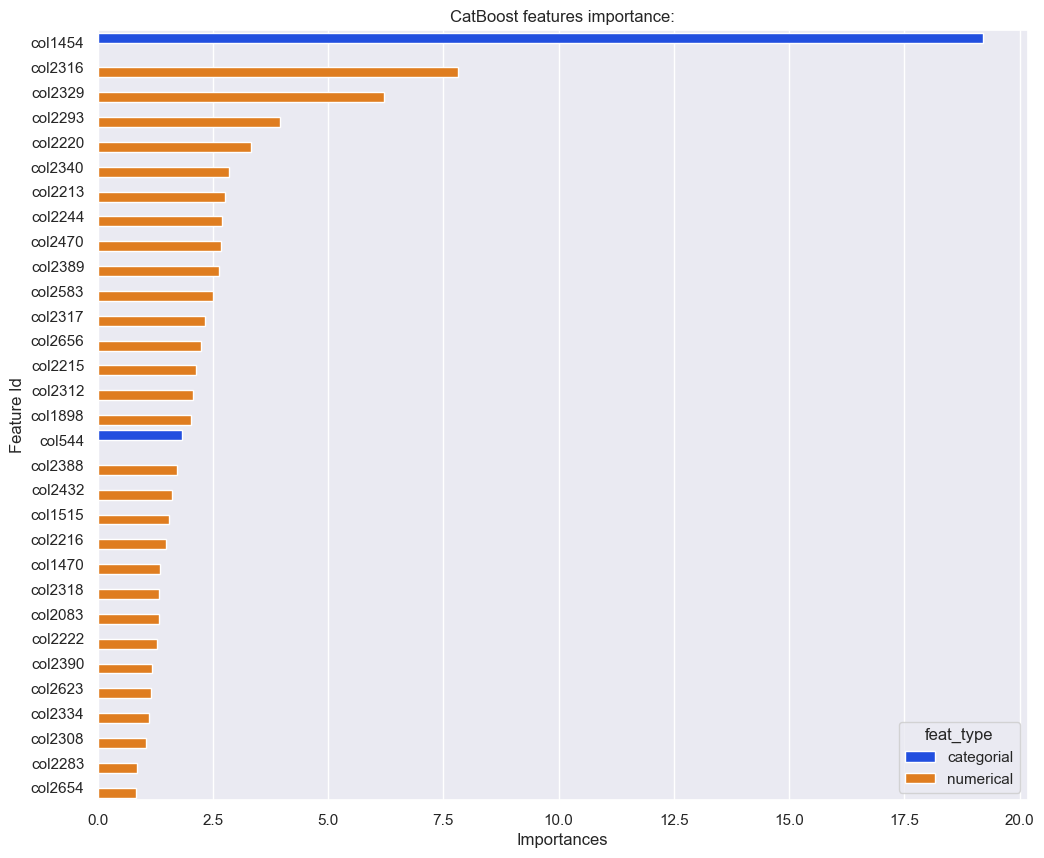

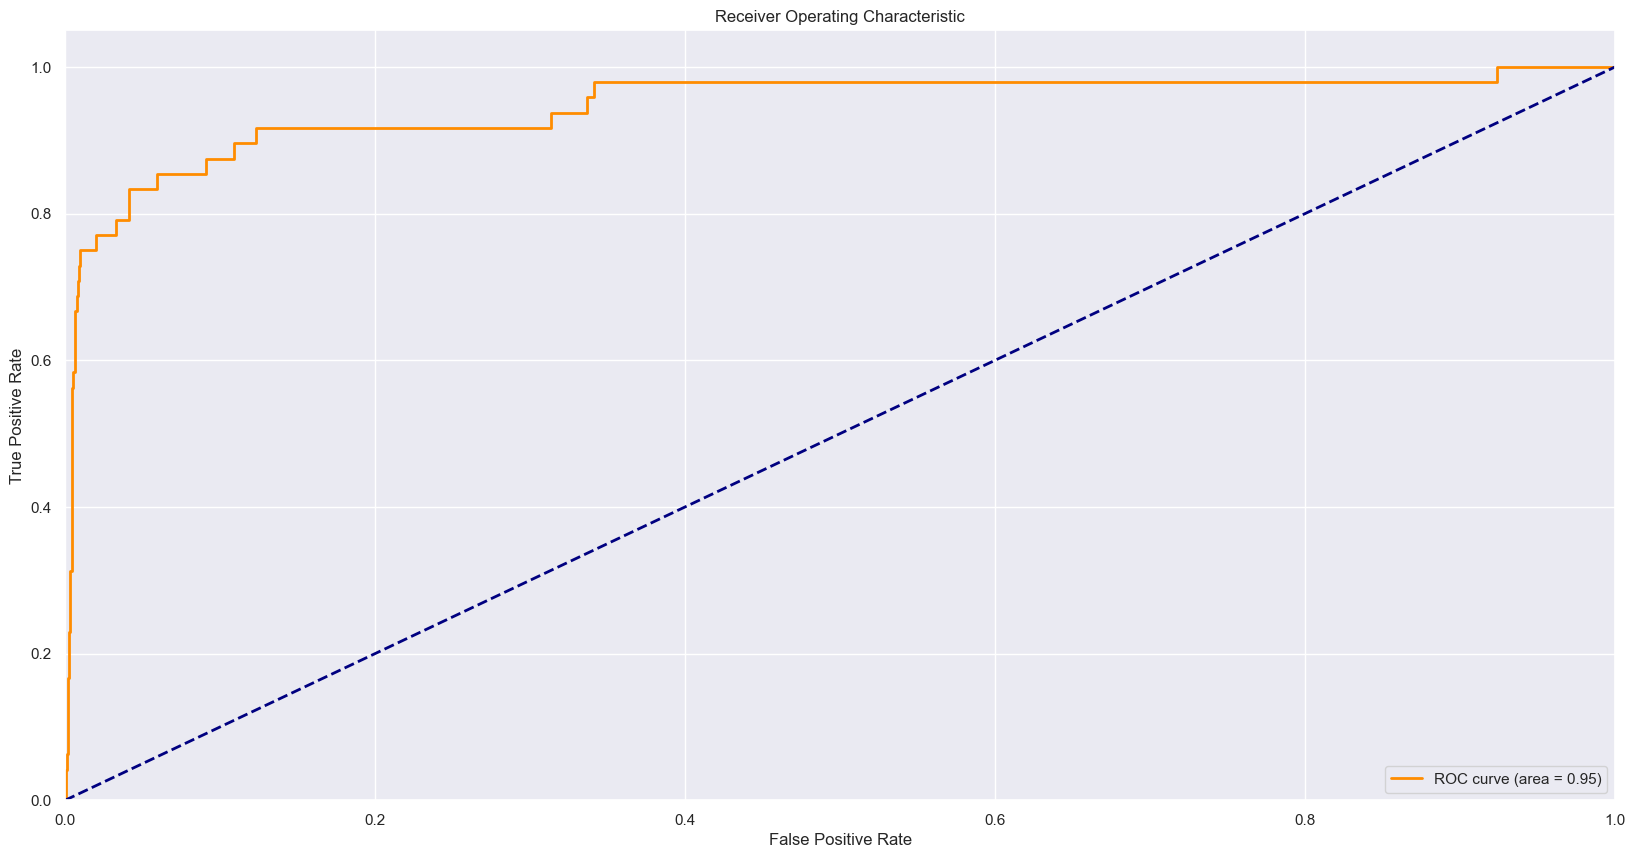

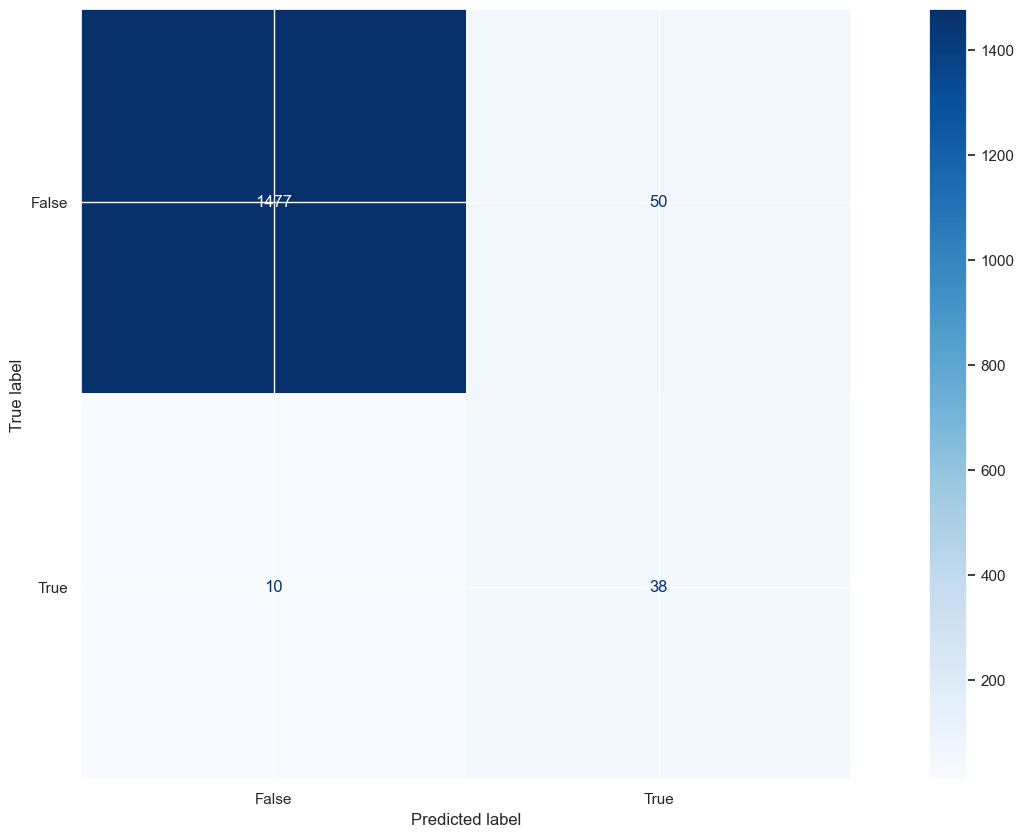

In [111]:
plot_model_info(
    model_best,
    X_test_cleaned,
    y_test,
)

# Step 8. Logistic Regression + CatBoost

In [58]:
# Get predictions from both models
cat_boost_preds = model_best.predict_proba(X_test_cleaned)[:, 1]
log_reg_preds = logreg_cv.predict_proba(test_pca)[:, 1]

# Average the predictions
# final_preds = np.mean([log_reg_preds, cat_boost_preds], axis=0)
preds = np.array([cat_boost_preds, log_reg_preds])
final_preds = np.average(preds, weights=[0.6, 0.4], axis=0)

# If you want to convert these to class predictions, you can do so like this:
final_class_preds = [1 if pred > 0.5 else 0 for pred in final_preds]

ROC-AUC score is:  0.900294695481336


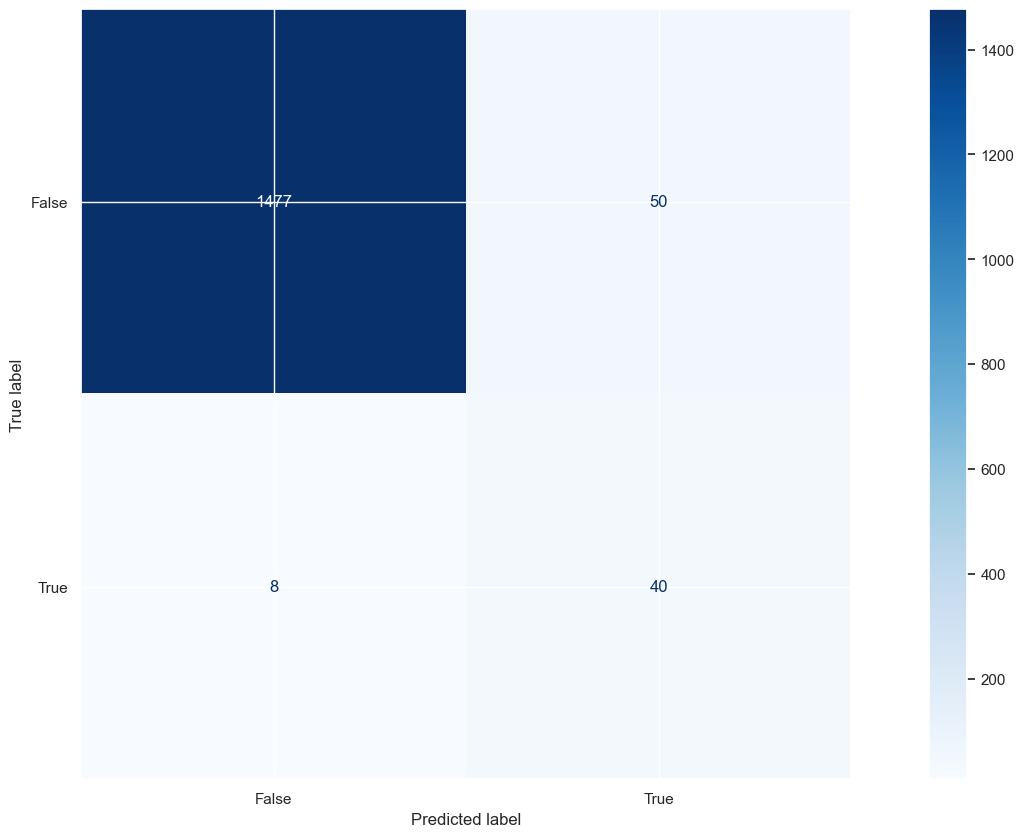

In [59]:
print("ROC-AUC score is: ", roc_auc_score(y_test, final_class_preds))
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, final_class_preds), display_labels=[False, True])
cm_display.plot(cmap="Blues")
plt.show()

# Step 9. Prediction

In [103]:
X_lead_orig = pd.read_csv("../data/raw/train_dataset_Самолет.csv")
# X_lead = pd.read_csv('')
X_lead = create_date_features(X_lead_orig)
X_lead = X_lead[not_null_columns_names]
X_lead = X_lead.drop(columns=["target", "client_id", "report_date"])

categorical_columns = (
    X_lead
    .select_dtypes(exclude=["float64", "int64"])
    .columns
)
numerical_columns = (
    X_lead
    .select_dtypes(include=["float64", "int64"])
    .columns
)
X_lead[numerical_columns] = X_lead[numerical_columns].fillna(0)
X_lead[categorical_columns] = X_lead[categorical_columns].astype(str)
logger.info("DONE - Initial Preprocessing")


X_lead_cleaned = X_lead.iloc[:, useful_column_indices]
X_lead_linear = preprocessor.transform(X_lead_cleaned)
X_lead_pca = pca.transform(X_lead_linear)[:, :top_n]
logger.info("DONE - Data transformation for pca")

# Get predictions from both models
cat_boost_preds = model_best.predict_proba(X_lead_cleaned)[:, 1]
log_reg_preds = logreg_cv.predict_proba(X_lead_pca)[:, 1]
logger.info("DONE - Model predictions")

# Average the predictions
# final_preds = np.mean([log_reg_preds, cat_boost_preds], axis=0)
preds = np.array([cat_boost_preds, log_reg_preds])
final_preds = np.average(preds, weights=[0.6, 0.4], axis=0)

# If you want to convert these to class predictions, you can do so like this:
final_class_preds = [1 if pred > 0.5 else 0 for pred in final_preds]

2023-09-09 23:13:04,205 INFO DONE - Initial Preprocessing
2023-09-09 23:13:04,463 INFO DONE - Data transformation for pca
2023-09-09 23:13:04,551 INFO DONE - Model predictions


In [105]:
# uncomment for leaderboard prediction
# X_lead_orig['target'] = final_class_preds